In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [50]:
class World:
    def __init__(self, N, M, car_dim):
        self.N = N
        self.M = M
        self.car_width, self.car_length = car_dim

        self.stops = self.generate_stops()
    
    def generate_stops(self):
        x = np.arange(self.car_width/2, self.N, self.car_width)
        y = np.arange(self.car_width/2, self.M, self.car_width)
        stops = [(i, j) for j in y for i in x]
        return stops

    def plot(self):
        fig = plt.figure(figsize=(self.N, self.M))
        ax = fig.add_subplot(111)

        # plot contours
        ax.plot([0, self.N], [0, 0], c='b')
        ax.plot([0, self.N], [self.M, self.M], c='b')
        ax.plot([0, 0], [0, self.M], c='b')
        ax.plot([self.N, self.N], [0, self.M], c='b')

        # plot stops
        ax.scatter(*zip(*self.stops))

        # plot car
        ax.plot([0, self.car_width], [0, 0], c='r')
        ax.plot([0, self.car_width], [self.car_length, self.car_length], c='r')
        ax.plot([0, 0], [0, self.car_length], c='r')
        ax.plot([self.car_width, self.car_width], [0, self.car_length], c='r')

        plt.show()


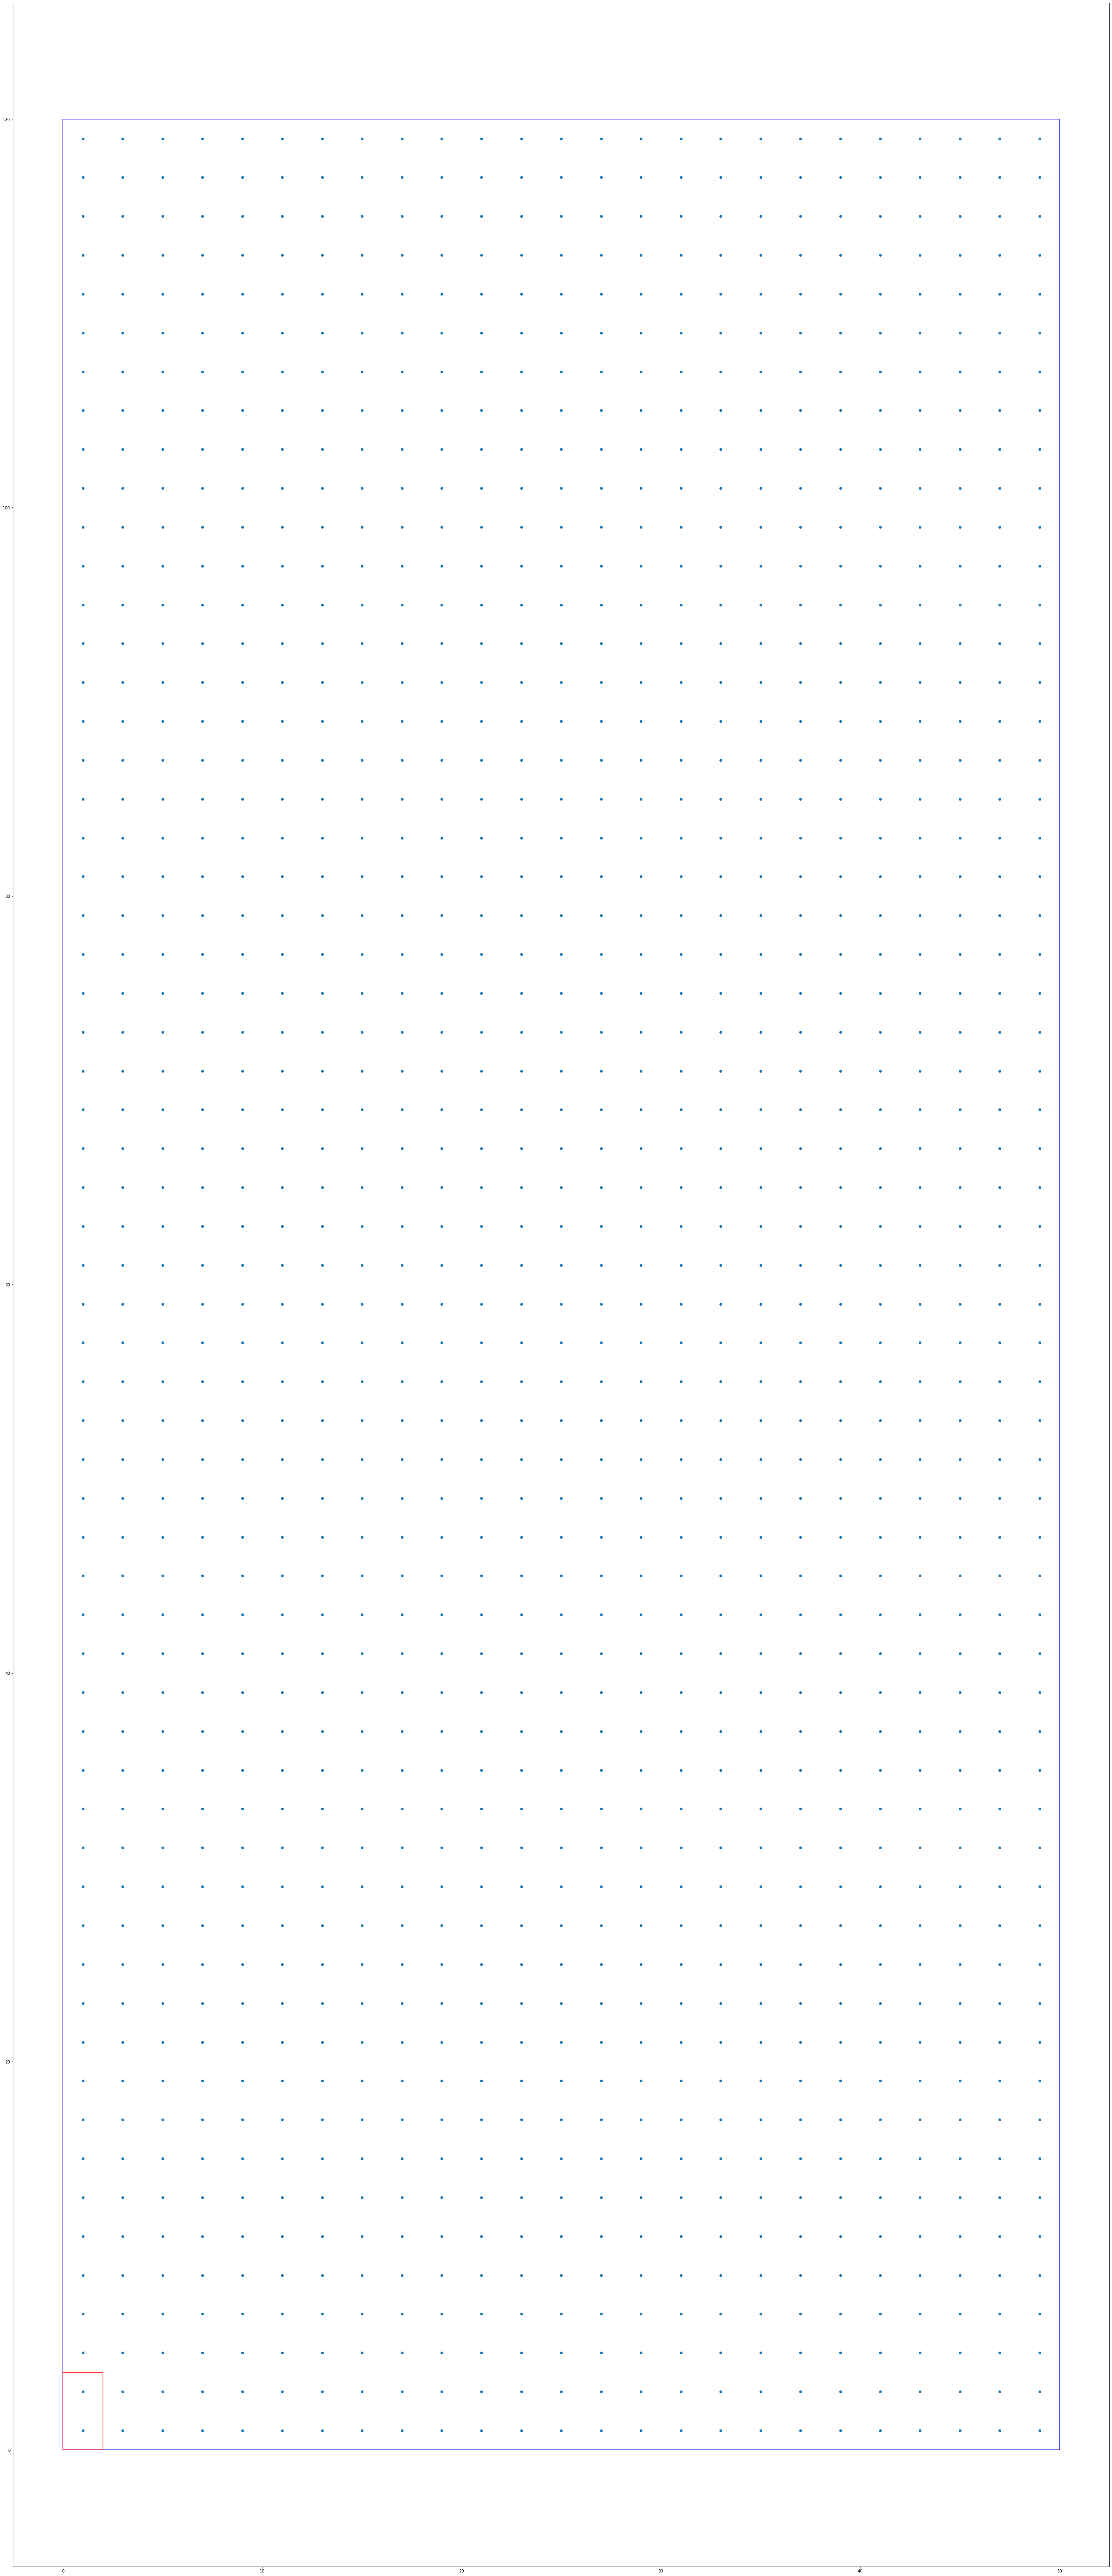

In [51]:
world = World(50, 120, (2, 4))
world.plot()

In [54]:
class TSP:
    def __init__(self, world, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999, gamma=0.95, learning_rate=0.8):
        self.world = world
        self.stops = self.world.stops
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.learning_rate = learning_rate        

        self.Q = self.init_Q()
        self.states_map = self.init_states_map()

        self.n_states = len(self.states_map)

    def init_Q(self):
        Q = cdist(self.stops, self.stops, 'euclidean')
        return Q

    def init_states_map(self):
        states_map = {}
        for i, stop in enumerate(self.stops):
            states_map[stop] = i
        return states_map

    def train(self, s, a, r, s_next):
        self.Q[s,a] = self.Q[s,a] + self.learning_rate * (r + self.gamma * np.max(self.Q[s_next,a]) - self.Q[s,a])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def act_eps_greedy(self, s):
        valid_a = self.get_valid_actions(s)
        if np.random.rand() <= self.epsilon:
            a = np.random.choice(valid_a)
        else:
            a = valid_a[np.argmax([self.Q[s,act] for act in valid_a])]
        return a
        
    def get_valid_actions(self, s):
        valid_a = list(set(self.states_map.keys()).remove(s))
        return valid_a
    
    def reset(self):
        self.path = []
        first_stop = np.random.randint(self.n_states)
        self.path.append(first_stop)
        return first_stop
    
    def transition(self, s, a):
        s_next = a
        reward = self.get_reward(s, s_next)
        self.path.append(s_next)
        done = len(self.path) == self.n_states
        return s_next, reward, done

    def get_reward(self, s, s_next):
        reward = self.Q[s,s_next]
        return reward


    def run_episode(self):
        s = self.reset()
        max_steps = self.n_states
        episode_reward = 0

        for _ in range(max_steps):
            a = self.act_eps_greedy(s)
            s1, r, done = self.transition(s,a)

            





    


In [55]:
tsp = TSP(world)